# Plotting the mutations density in the genes

Are there specific genes in which a significant portion of the mutations fall?
We want to answer this by finding the distribution of the number of mutations per gene.
That is, for each integer, we want to know how many genes have that number of mutations.

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

We first map genes to the number of mutations they harbor (read from a random sample of 100,000 mutations)

In [11]:
from collections import Counter
from ICGC_data_parser import SSM_Reader

mutations_per_gene = Counter()

mutations = SSM_Reader(filename='data/ssm_sample.vcf')
CONSEQUENCE = mutations.subfield_parser('CONSEQUENCE')

for record in mutations:
    affected_genes = [c.gene_symbol for c in CONSEQUENCE(record) if c.gene_symbol]
    mutations_per_gene.update(affected_genes)
    
mutations_per_gene.most_common(5)

[('PCDH15', 1651),
 ('RBFOX1', 1041),
 ('CSMD1', 979),
 ('DLG2', 941),
 ('SPOCK3', 929)]

Now we want to group by number of mutations

In [12]:
distribution = Counter(mutations_per_gene.values())
distribution.most_common(10)

[(1, 8600),
 (2, 3624),
 (3, 1638),
 (4, 1403),
 (6, 1001),
 (5, 877),
 (8, 712),
 (7, 687),
 (9, 535),
 (10, 522)]

Now we plot the data...

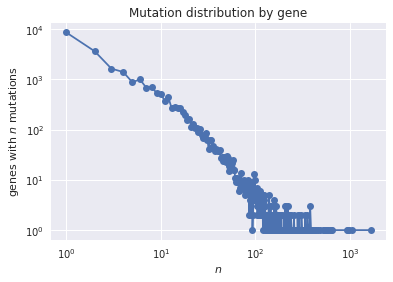

In [22]:
x = sorted(distribution.keys())
y = [distribution[i] for i in x]

plt.plot(x, y, marker='o')
plt.yscale('log')
plt.xscale('log')
plt.title('Mutation distribution by gene')
plt.xlabel('$n$')
plt.ylabel('genes with $n$ mutations')
plt.show()